# Our Main Notebook for the Stock Trading Project

In [0]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

## OUR DATABASE

In [0]:
# S&P Prices Table
spx = pd.read_csv("https://gist.githubusercontent.com/aaron-gu/44f2bb12ac5e345b5337600d17659348/raw/6283525cd2063fd886c3f783f63834dc418fd5e9/spx.csv", header=0)
spx.columns = ['date', 'prices']
spx["date"] = pd.to_datetime(spx["date"])
spx = spx.set_index("date").to_dict('dict')

# Prices of every stock in the table from May 2015 - August 2018
price_date = pd.read_csv("https://gist.githubusercontent.com/aaron-gu/1b7dcab92e0865b2ee62e3d7a056d0bc/raw/5d1bde67628b12c11e891478b773dc99c1bae6e8/price_date.csv", header=0)
price_date["date"] = pd.to_datetime(price_date["date"])
price_date = price_date.set_index(["ticker", "date"]).to_dict('index')

# The split test set that we took out
hidden_test = pd.read_csv("https://gist.githubusercontent.com/sethsaps123/1f4768285251e8e8f256800b9bc2a56e/raw/ad26a662402c0f6ee975b57122f33b0148ae2224/hidden_test_set")
hidden_test.fillna({"type": "NOT_FACILITY"}, inplace=True)
hidden_test["buy_date"] = pd.to_datetime(hidden_test["buy_date"])
hidden_test["sell_date"] = pd.to_datetime(hidden_test["sell_date"])

# The training set we used
advan = pd.read_csv("https://gist.githubusercontent.com/sethsaps123/4dba62fe222b147d326993c9839e070c/raw/475cb401eabc0547a8117c8429b2b0250b39fd47/advan_Jun28", header=0)
advan.fillna({"type": "NOT_FACILITY"}, inplace=True)
advan["buy_date"] = pd.to_datetime(advan["buy_date"])
advan["sell_date"] = pd.to_datetime(advan["sell_date"])

# All of the data from Advan
all_data = pd.read_csv("https://gist.githubusercontent.com/aaron-gu/9bca737aaccba241bb08b313be6c2bb7/raw/53948c6b4b3c240752e508c7f5749cdb09b5ecce/advan_cleaned.csv", header=0)
all_data.fillna({"type": "NOT_FACILITY"}, inplace=True)
all_data["buy_date"] = pd.to_datetime(all_data["buy_date"])
all_data["sell_date"] = pd.to_datetime(all_data["sell_date"])
all_data['merge_col'] = all_data['ticker'] + all_data['start'].map(str)
all_data['long_short'] = all_data.apply(lambda x: 1 if x['advan_forecast'] > x['estimate'] else 0, axis=1)

# X-Mode only data (majority is from January 1, 2018 to July 31, 2018)
xmode_advan = pd.read_csv("https://gist.githubusercontent.com/aaron-gu/8c5a304f13f0fd6f5e0600511432e376/raw/9d5dbdae73a6b9d261960ca1f54f2fb9c767a06e/xmode_advan.csv", header=0)
xmode_advan.fillna({"type": "NOT_FACILITY"}, inplace=True)
xmode_advan['merge_col'] = xmode_advan['ticker'] + xmode_advan['start'].map(str)
xmode_advan['long_short'] = xmode_advan.apply(lambda x: 1 if x['advan_forecast'] > x['estimate'] else 0, axis=1)

In [0]:
test(all_data).to_csv('all_data.csv', index=0)
test(merged).to_csv('xmode_data.csv', index=0)

In [0]:
from google.colab import files
files.download('xmode_data.csv')
files.download('all_data.csv')

In [28]:
all_data['sector'].value_counts()

Consumer Cyclical     502
Industrials           294
Basic Materials       109
Real Estate            95
Energy                 89
Technology             78
Consumer Defensive     70
Financial Services     55
Healthcare             27
Name: sector, dtype: int64

In [0]:
# This method appends the data we scraped on all_data to the xmode only dataset.
merged = xmode_advan.join(all_data.set_index('merge_col'), how='inner', on='merge_col', rsuffix='_all')

In [32]:
test(merged).groupby('sector').mean()[['return', 'sp_return']]

,return,sp_return
sector,,
Basic Materials,-0.016236,0.022730
Consumer Cyclical,0.064582,0.026752
Consumer Defensive,-0.002634,0.020285
Energy,0.155945,0.024247
Financial Services,0.035302,0.034385
Healthcare,0.049103,0.034053
Industrials,-0.018215,0.030645
Real Estate,0.048663,0.033170
Technology,0.049370,0.029290


## Prototype Test function

In [0]:
def test(chosen_stocks):
  """
  adds the columns:
  'buy_price', 'sell_price', 'sp_buy_price', 'sp_sell_price', 'return', 'sp_return'
  to a table
  by checking prices on the buy and sell date
  """
  chosen_stocks = chosen_stocks.copy()
  all_stock_close = []
  all_sp_close = []
  all_stock_open = []
  all_sp_open = []
  for row in range(len(chosen_stocks)):
    ticker = chosen_stocks.iloc[row]["ticker"]
    
    # adding open prices
    buy_date = chosen_stocks.iloc[row]["buy_date"]
    open_price = check_price(ticker, buy_date)
    sp_open_price = check_price_sp(buy_date)
    all_stock_open.append(open_price)
    all_sp_open.append(sp_open_price)

    # adding close prices
    sell_date = chosen_stocks.iloc[row]["sell_date"]
    close_price = check_price(ticker, sell_date)
    sp_close_price = check_price_sp(sell_date)
    all_stock_close.append(close_price)
    all_sp_close.append(sp_close_price)

  chosen_stocks["buy_price"] = all_stock_open
  chosen_stocks["sell_price"] = all_stock_close
  chosen_stocks["sp_buy_price"] = all_sp_open
  chosen_stocks["sp_sell_price"] = all_sp_close
  
  # drop the stocks that don't have a buy/sell price
  chosen_stocks.dropna(inplace=True, subset=["buy_price", "sell_price", "sp_buy_price", "sp_sell_price"])
  chosen_stocks.reset_index(drop=True, inplace=True)
  
  chosen_stocks["return"] = (chosen_stocks["sell_price"] - chosen_stocks["buy_price"]) / chosen_stocks["buy_price"]
  chosen_stocks["sp_return"] = (chosen_stocks["sp_sell_price"] - chosen_stocks["sp_buy_price"]) / chosen_stocks["sp_buy_price"]

  for row in range(len(chosen_stocks)):
    #absolute value, then checking for the shorted-loss case or longed-loss case
    chosen_stocks.at[row, "return"] = abs(float(chosen_stocks.iloc[row]["return"]))
    if chosen_stocks.iloc[row]["advan_forecast"] > chosen_stocks.iloc[row]["estimate"]:
      if chosen_stocks.iloc[row]["sell_price"] < chosen_stocks.iloc[row]["buy_price"]:
        chosen_stocks.at[row, "return"] = chosen_stocks.iloc[row]["return"] * -1
    elif chosen_stocks.iloc[row]["sell_price"] > chosen_stocks.iloc[row]["buy_price"]:
      chosen_stocks.at[row, "return"] = chosen_stocks.iloc[row]["return"] * -1

  #print("Average stock return: ", (chosen_stocks["return"]).mean(), " Average S&P500 return: ", (chosen_stocks["sp_return"]).mean())

  return chosen_stocks #(chosen_stocks["return"]).mean(), (chosen_stocks["sp_return"]).mean()

In [0]:
def check_price(ticker, date):
  """
  Accesses the price_date table and returns the price of the ticker for the specified date
  If that date cannot be found, 4 days in the future will be searched
  """
  if ticker == "SPX":
    return check_price_sp(date)
  for i in range(4):
    try:
      return price_date[(ticker, date)]['prices']
    except KeyError:
      date = date + datetime.timedelta(days=1)
  return np.nan

In [0]:
def check_price_sp(date):
  """
  Accesses the spx table and returns the s&p500 price for the specified date
  If that date cannot be found, 6 days in the future will be searched
  If there is no data for those 6 days, then return NaN
  """
  
  for i in range(4):
    try:
      return spx["prices"][date]
    except KeyError:
      date = date + datetime.timedelta(days=1)
  return np.nan

In [0]:
def check_moving_average(ticker, date):
  """
  Accesses the price_date table and returns the 50 day moving average of the ticker for the specified date
  If that date cannot be found, 4 days in the future will be searched
  """

  for i in range(4):
    try:
      return price_date[(ticker, date)]['moving_average']
    except KeyError:
      date = date + datetime.timedelta(days=1)
  return np.nan

# Strategies

In [0]:
def date_change_strategy(table, start_change=2, end_change=5):
  """
  Takes in an advan table of stocks with the quarter end date and revenue report date
  and changes them by start_change and end_change
  """
  
  copy = table.copy()
  copy["buy_date"] = copy["buy_date"] + datetime.timedelta(days=start_change)
  copy["sell_date"] = copy["sell_date"] + datetime.timedelta(days=end_change)
  return copy

In [0]:
def pct_change_strategy(table, threshold_min, threshold_max = 1000):
  """
  Takes in advan, calculates the difference between the analyst estimate and advan estimate,
  returns the stocks that have a difference above the specified threshold
  """
  copy = table.copy()
  copy["diff"] = (copy["advan_forecast"] - copy["estimate"]) / copy["estimate"]
  copy["diff"] = copy["diff"].abs()
  return copy[(copy["diff"] > threshold_min) & (copy["diff"] < threshold_max)]

In [0]:
def historical_beats_strategy(table, lower_bound):
  unique_stocks = table.groupby("ticker").count()
  unique_stocks = unique_stocks[unique_stocks["start"] > 4]
  unique_stocks_sum = table.groupby("ticker").sum()
  good = unique_stocks[["correct_beat_or_miss"]].join(unique_stocks_sum[["correct_beat_or_miss"]], how="inner", lsuffix="_unique")
  good["ratio_correct"] = good["correct_beat_or_miss"]/good["correct_beat_or_miss_unique"]
  good_filtered = good[good["ratio_correct"] > lower_bound]
  
  ticker_list = good_filtered.index.values
  #print(ticker_list)
  return table[table["ticker"].isin(list(ticker_list))]

In [0]:
def new_historical_beats_strategy(table):
  # this version is used on the xmode_data, because you can't get the historical beats misses from that dataframe
  tickers = ['A', 'AIV', 'ALSN', 'APD', 'AVY', 'BAX', 'BBY', 'BKU', 'BRKS', 'BSX', 'BWA', 'BXP',
  'CHDN', 'DAN', 'DCI', 'DDS', 'EGOV', 'ENS', 'F', 'FLEX', 'FSS', 'FUL', 'GTY', 'HBAN',
  'ITT', 'KIM', 'KORS', 'LULU', 'OLLI', 'OSK', 'PII', 'PLCE', 'RJF', 'TLYS',
  'TWI', 'UHAL', 'VLO', 'VMC', 'VTNR', 'WCN', 'WM', 'ZTS', 'ZUMZ']
  return table[table['ticker'].isin(tickers)]

In [0]:
def long_strategy(table, long=True):
  if long:
    return table[table["long_short"] == 1]
  else:
    return table[table["long_short"] == 0]

def sector_strategy(table):
  return table[table['sector'].isin(['Energy', 'Technology', 'Consumer Cyclical'])]

def facility_strategy(table, facility):
  if facility:
    return table[table["type"] == "FACILITY"]
  else:
    return table[table["type"] == "NOT_FACILITY"]
  
def beta_strategy(table, threshold):
  return table[table["beta"] >= threshold]

## Testing strategies and combos of strategies

In [0]:
def mult_pct_change(table, visualize_bool=False):
  '''
  takes in table and runs 10 diff thresholds and returns the table with the best diff in returns
  '''
  new_advan = pct_change_strategy(table, 0)
  quantiles = new_advan["diff"].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
  best_change = 0
  best = 0
  for pct in quantiles:
    new_advan = pct_change_strategy(new_advan, pct)
    samp, stock_return, sp_return = test(new_advan)
    change = stock_return - sp_return
    print("change in return with threshold of ", pct, " is ", change)
    if change > best_change:
      best_change = change
      best = pct
    if visualize_bool:
      visualize(new_advan, int(len(new_advan)*0.1))
  return pct_change_strategy(table, best)

In [0]:
def test_date_change(table):  
  best_return = -1000
  sp_best = -1000
  best_start_date = 0
  best_end_date = 0
  best_difference = -1000
  for i in range(-9, 9):
    for j in range(0, 9):
      new_advan = date_change_strategy(table, i, j)
      final_table, stock_return, sp_return = test(new_advan)
      if stock_return - sp_return > best_difference:
        best_return = stock_return
        sp_best = sp_return
        best_start_date = i
        best_end_date = j
        best_difference = stock_return - sp_return
      print(i, j, stock_return - sp_return)
  return best_return, sp_best, best_start_date, best_end_date, best_difference

In [0]:
def visualize(samp, sample_size):
  returns = []
  spreturns = []
  for i in range(1000):
    s = samp.sample(sample_size)
    returns.append(s["return"].mean())
    spreturns.append(s["sp_return"].mean())

  plt.hist(returns, bins=20)
  plt.xlabel('Return')
  plt.ylabel('Probability')
  plt.title('Returns On 1000 Different Buy2 and Sell5 Samples')
  plt.grid(True)
  plt.show()
  
  print("mean", np.array(returns).mean())
  print("stddev", np.array(returns).std())
  print(np.array(spreturns).mean())
  print("Difference between us and S&P with 1000 samples", np.array(returns).mean() - np.array(spreturns).mean())

# BACKTESTING/PORTFOLIO STRATEGIES

with classes for Portfolio types and Stake

In [0]:
class Stake:
  '''the class used by both portfolios'''
  def __init__(self, t, m, d, longshort):
    self.ticker = t
    self.money = m
    self.last_price = check_price(t, d)
    self.long_or_short = longshort
  
  def update(self, day, to_print = False):
    today = check_price(self.ticker, day)
    if today is np.nan:
      today = self.last_price
    
    pct_change = (today - self.last_price) / self.last_price
    if self.long_or_short:
      self.money = self.money * (1 + pct_change)
    else:
      self.money = self.money * (1 - pct_change)
    if to_print:
      print("updating", self.ticker, self.last_price, today, self.money)
    self.last_price = today

In [0]:
class EvenPortfolio:
  def __init__(self, stake_list=[], money=10000, d=pd.to_datetime("2015/08/01")):
    self.stakes = stake_list
    self.total_money = money
    self.start_money = money
    self.day = d


  def update(self, d):
    """Iterates through each stake in the portfolio and updates the money in it"""
    self.day = d
    if len(self.stakes) == 0:
      return
    
    # check for stocks without data and sell them (remove them from portfolio)
    to_sell = []
    for stake in self.stakes:
      if stake.last_price is np.nan:
        to_sell.append(stake.ticker)
      else:
        stake.update(d)
    self.sell_stocks(to_sell)
    
    self.update_total_money()
      
      
  def update_total_money(self):
    """Calculates and updates the portfolio value"""
    if len(self.stakes) == 0:
      return
 
    tot = 0
    for stake in self.stakes:
      tot += stake.money
    self.total_money = tot
    
    
  def sell_stocks(self, stocks):
    """Takes in a single stock or list of stocks (tickers) and sells them"""
    if len(stocks) == 0:
      return
    if type(stocks) is str:
      stocks = [stocks]

    # checking if the stocks being sold are in the portfolio
    new_stocks = []
    for stock in stocks:
      for stake in self.stakes:
        if stock == stake.ticker:
          new_stocks.append(stock)
    if len(new_stocks) == 0:
      return
    
    new_stakes = []
    free_money = 0
    for stake in self.stakes:
      if stake.ticker not in new_stocks:
        new_stakes.append(stake)
      else:
        free_money += stake.money
    self.stakes = new_stakes
    self.distribute_money(free_money)
    
  def distribute_money(self, free_money):
    if len(self.stakes) == 0:
      self.total_money = free_money
    for stake in self.stakes:
      stake.money = stake.money + free_money/len(self.stakes)

      
      
  def buy_stocks(self, stocks, long_short):
    """Takes in a single stock or list of stocks and a list of long/short booleans, recalculates stakes and distributes money, and adds new stakes"""
    
    if len(stocks) == 0:
      return
    if type(stocks) is str:
      stocks = [stocks]
    if type(long_short) is int:
      long_short = [long_short]
      
    num_stocks = len(stocks) + len(self.stakes)
    if len(self.stakes) == 0:
      for i in range(len(stocks)):
        self.stakes.append(Stake(stocks[i], self.total_money * 1/num_stocks, self.day, long_short[i]))
    else:
      free_money = 0
      for stake in self.stakes:
        free_money += stake.money * len(stocks)/num_stocks
        stake.money = stake.money * (1 - len(stocks)/num_stocks)
      for i in range(len(stocks)):
        self.stakes.append(Stake(stocks[i], free_money * 1/len(stocks), self.day, long_short[i]))
  
  
  def get_total_gains(self):
    return self.total_money, self.start_money, (self.total_money - self.start_money) / self.start_money

In [0]:
def backtest_redistribute(table, start_date, end_date, starting_value=10000):
  """
  Puts 100% of money into the stocks being traded at one time, and redistributes if more stocks need to be traded
  returns a list of portfolio value over the specified date range
  """
  
  portfolio = EvenPortfolio([], starting_value, start_date)
  trading_range = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date))
  
  money = []
  
  for day in trading_range:
    portfolio.update(day)
    
    sell = table[table["sell_date"] == day]
    portfolio.sell_stocks(sell["ticker"].values)
    
    buy = table[table["buy_date"] == day]
    portfolio.buy_stocks(buy["ticker"].values, buy["long_short"].values)
    
    money.append(portfolio.total_money)
  
  #print(portfolio.get_total_gains())
  
  return money

In [0]:
class QuarterlyPortfolio:
  def __init__(self, stake_list, money, table_, dates_):
    self.stakes = stake_list
    self.total_money = money
    self.table = table_
    self.total_money_graph = []
    self.dates = pd.to_datetime(pd.Series(dates_), infer_datetime_format=True)
    self.max_freq = []
    self.sp_stake = Stake("SPX", money, pd.to_datetime('01/01/2018'), True)
    
  def get_max_freq(self):
    for count in range(len(self.dates) - 1):
      self.max_freq.append(max_trading_frequency(self.table, self.dates[count], self.dates[count + 1]))    
    
  def update_stake(self, day):
    for ticker in self.stakes:
      ticker.update(day, False)
    self.sp_stake.update(day, False)
    self.update_total_money()
  
  def update_total_money(self):
    tot = 0
    for ticker in self.stakes:
      tot += ticker.money
    tot += self.sp_stake.money
    self.total_money = tot
    self.total_money_graph.append(self.total_money)
    
  def change_sp_stake(self, amount):
    self.sp_stake.money += amount
    
  def run(self):
    self.max_freq = []
    self.get_max_freq()
    total_freq = 0
    for count in range(len(self.dates) - 1):
      # account for transition aka stocks in stakes where not buy date
      for stake in self.stakes:
        self.change_sp_stake(stake.money)
        stake.money = 0
      self.update_total_money()
      
      
      num_ways_split = (self.max_freq[count] + len(self.stakes))
      if num_ways_split == 0:
        num_ways_split = 1
      dollar_per_stock = self.total_money / float(num_ways_split)
      date_range = pd.date_range(self.dates[count], self.dates[count + 1])
      
      # buy back transition stocks after dollar_per_stock is recalculated
      for stake in self.stakes:
        stake.money = dollar_per_stock
        self.change_sp_stake(dollar_per_stock * -1.0)
       
      for date in date_range:
        self.update_stake(date)
        todays_buys = self.table[self.table["buy_date"] == date]
        for row in range(len(todays_buys)):
          new_stake = Stake(todays_buys.iloc[row]["ticker"], dollar_per_stock, date, todays_buys.iloc[row]["long_short"])
          self.stakes.append(new_stake)
          self.change_sp_stake(dollar_per_stock * -1)

        to_sell = []
        todays_sells = self.table[self.table["sell_date"] == date]
        for row in range(len(todays_sells)):
          to_sell.append(todays_sells.iloc[row]["ticker"])

        new_stakes = []
        for stake in self.stakes:
          if stake.ticker not in to_sell:
            new_stakes.append(stake)
          else:
            self.change_sp_stake(stake.money)
        self.stakes = new_stakes

In [0]:
def max_trading_frequency(table, start_date, end_date):
  '''
  takes in a table with all trades and a range and returns the max number of
  trades that occur at the same time in that range
  '''
  dates = []
  table = table[table['buy_date'] >= pd.to_datetime(start_date)]
  for row in range(len(table)):
    daterange = pd.date_range(table.iloc[row, 3], table.iloc[row, list(table.columns).index('buy_date')])
    for date in daterange:
      dates.append(date)
  trading_dates = pd.DataFrame({"dates": dates, "trades": 1})
  mygraph = trading_dates.groupby(dates).count()
  #plt.plot(mygraph.index.values, mygraph['trades'])
  #plt.show()
  mygraph.drop('dates', axis=1, inplace=True)
  
  max_count = 0

  for row in range(len(mygraph)):
    if (pd.to_datetime(start_date) <= mygraph.iloc[row].name <= pd.to_datetime(end_date)) and (mygraph.iloc[row]["trades"] > max_count):
      max_count = mygraph.iloc[row]["trades"]
  
  return max_count

In [0]:
def backtest_divide(table, dates):
  '''
  Take in a table of stocks with dates and ticker. Applies a dollar
  per max number of overlap in that quarter to allocate money
  to certain stocks. Other goes in S&P
  '''
  portfolio = QuarterlyPortfolio([] , 100.00, table, dates)
  portfolio.run()
  return portfolio.total_money_graph

## Testing Portfolios

In [0]:
def sp_plot(money, start_date, end_date):
  '''returns a list of prices for the S&P500 from start_date to end_date'''
  moneys = []
  sp_stake = Stake("SPX", money, start_date, 1)
  for date in pd.date_range(start_date, end_date):
    sp_stake.update(date)
    moneys.append(sp_stake.money)
  return moneys

In [0]:
def test_graph_portfolios(table, start_date, end_date, trading_periods):
  '''test portfolio returns and graphs them'''
  new_table = test(table)
  money_per_day = backtest_divide(new_table, trading_periods)
  money_per_day_even = backtest_redistribute(new_table, start_date, end_date, 100.0)
  
  days = []
  date = pd.to_datetime(start_date)
  for day in range(len(money_per_day)):
    days.append(date)
    date = date + datetime.timedelta(days=1)
  
  sp_money = sp_plot(100.00, pd.to_datetime(start_date), pd.to_datetime(end_date))
  
  while len(sp_money) < len(money_per_day):
    sp_money.append(sp_money[-1])
  while len(money_per_day) < len(sp_money):
    money_per_day.append(money_per_day[len(money_per_day) - 1])
  
  while len(sp_money) < len(money_per_day_even):
    sp_money.append(sp_money[-1])
  while len(money_per_day_even) < len(sp_money):
    money_per_day_even.append(money_per_day_even[len(money_per_day_even) - 1])
    
  print("Total Number of Trades: ", len(new_table[new_table['buy_date'] >= pd.to_datetime('01/01/2018')]))
  
  plt.plot(days, money_per_day, label='Quarterly Portfolio')
  plt.plot(days, money_per_day_even, label="Even Portfolio")
  plt.plot(days, sp_money, label='S&P 500')
  plt.legend(loc='upper left')
  plt.xlabel("Date")
  plt.ylabel("Portfolio Value")
  plt.show()
  
  returns = ((money_per_day[len(money_per_day) - 1] - 100.00) / 100.00)
  sp_returns = ((sp_money[len(sp_money) - 1] - 100.00) / 100.00)
  print("Quarterly Portfolio Return: {:.2f}%".format(returns*100))
  print("S&P Return: {:.2f}%".format(sp_returns*100))
  print("Percent Points above S&P for Quarterly Portfolio: {:.2f}%".format((returns - sp_returns)*100))
  print("")
  returns = ((money_per_day_even[len(money_per_day_even) - 1] - 100.00) / 100.00)
  sp_returns = ((sp_money[len(sp_money) - 1] - 100.00) / 100.00)
  print("Even Portfolio Return: {:.2f}%".format(returns*100))
  print("S&P Return: {:.2f}%".format(sp_returns*100))
  print("Percent Points above S&P for Even Portfolio: {:.2f}%".format((returns - sp_returns)*100))

JUST ALL_DATA
Total Number of Trades:  152


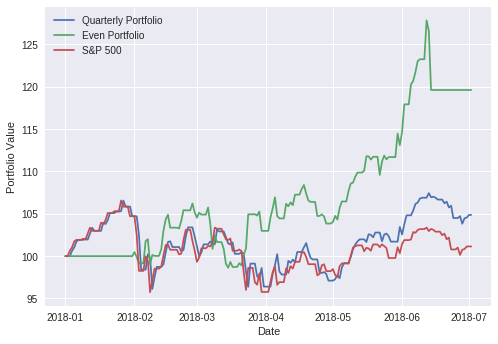

Quarterly Portfolio Return: 4.87%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 3.72%

Even Portfolio Return: 19.62%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 18.48%
HISTORICAL BEATS STRATEGY
Total Number of Trades:  42


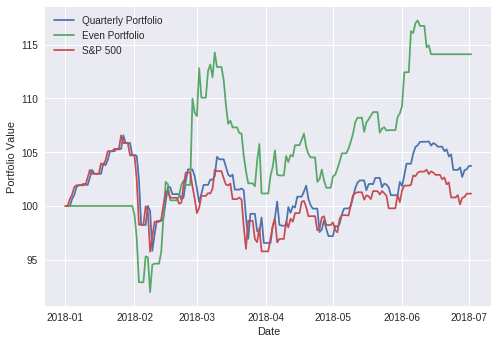

Quarterly Portfolio Return: 3.72%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 2.58%

Even Portfolio Return: 14.11%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 12.96%
PCT CHANGE STRATEGY
Total Number of Trades:  66


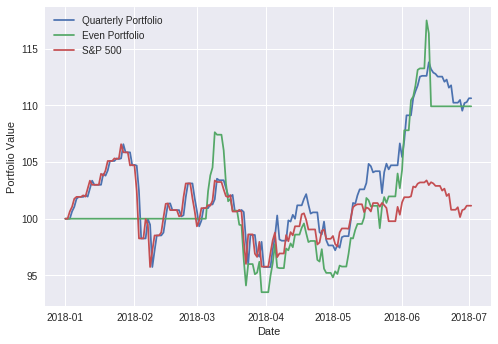

Quarterly Portfolio Return: 10.62%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 9.47%

Even Portfolio Return: 9.91%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 8.76%
DATE CHANGE STRATEGY 4,6
Total Number of Trades:  259


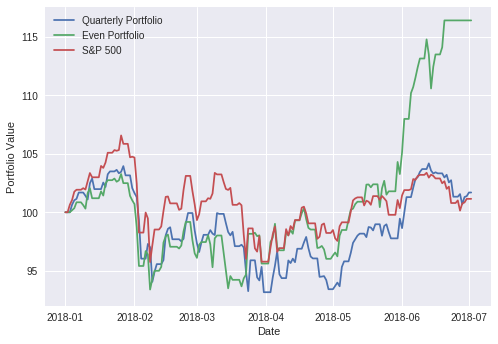

Quarterly Portfolio Return: 1.69%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 0.54%

Even Portfolio Return: 16.41%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 15.26%
SECTOR STRATEGY
Total Number of Trades:  19


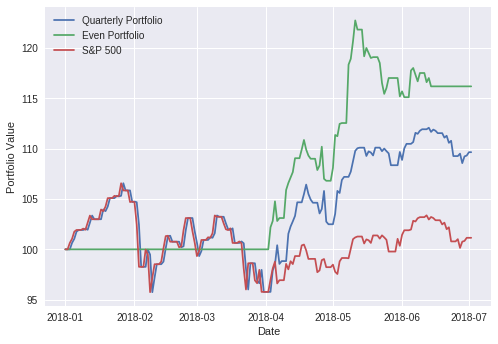

Quarterly Portfolio Return: 9.65%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 8.51%

Even Portfolio Return: 16.19%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 15.04%
LONG STRATEGY
Total Number of Trades:  150


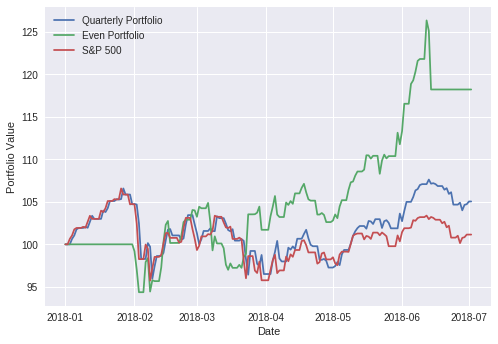

Quarterly Portfolio Return: 5.04%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 3.89%

Even Portfolio Return: 18.20%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 17.05%
FACILITY STRATEGY
Total Number of Trades:  62


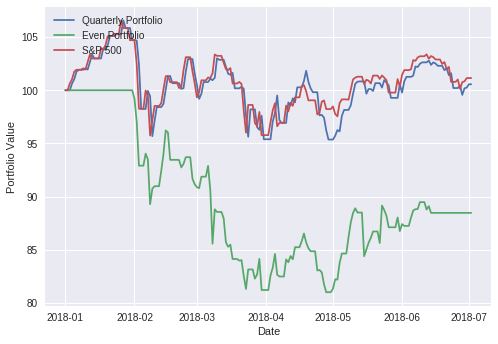

Quarterly Portfolio Return: 0.56%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: -0.58%

Even Portfolio Return: -11.53%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: -12.68%
BETA STRATEGY 1.0
Total Number of Trades:  67


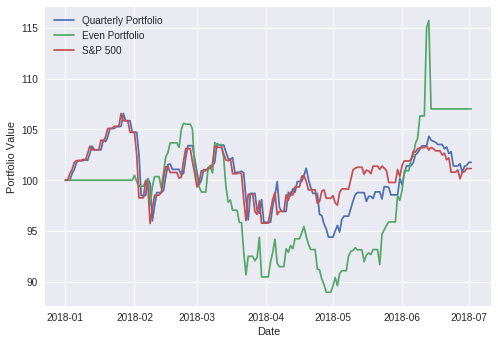

Quarterly Portfolio Return: 1.76%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 0.61%

Even Portfolio Return: 7.01%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 5.87%
BETA STRATEGY 1.5
Total Number of Trades:  23


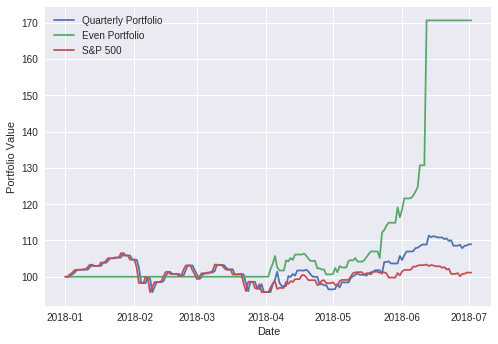

Quarterly Portfolio Return: 8.94%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 7.80%

Even Portfolio Return: 70.61%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 69.47%
HISTORICAL BEATS & PCT CHANGE & DATE CHANGE
Total Number of Trades:  22


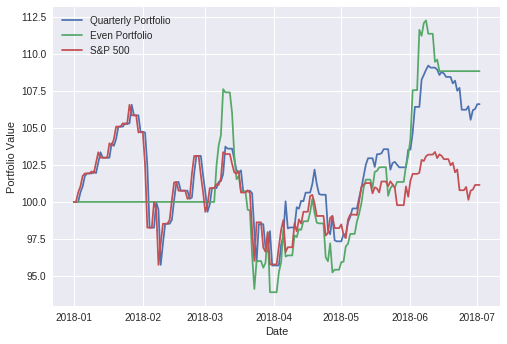

Quarterly Portfolio Return: 6.61%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 5.46%

Even Portfolio Return: 8.84%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 7.69%
HISTORICAL BEATS & DATE CHANGE & LONG & SECTOR & FACILITY
Total Number of Trades:  1


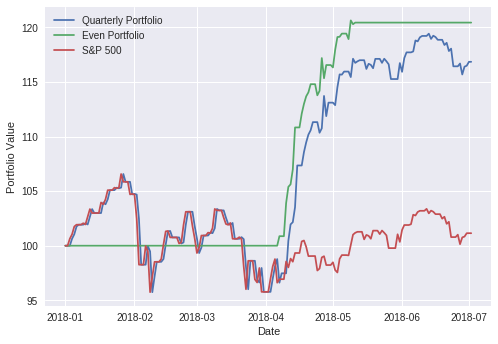

Quarterly Portfolio Return: 16.84%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 15.70%

Even Portfolio Return: 20.43%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 19.29%
PCT CHANGE & DATE CHANGE & LONG & SECTOR & FACILITY
Total Number of Trades:  7


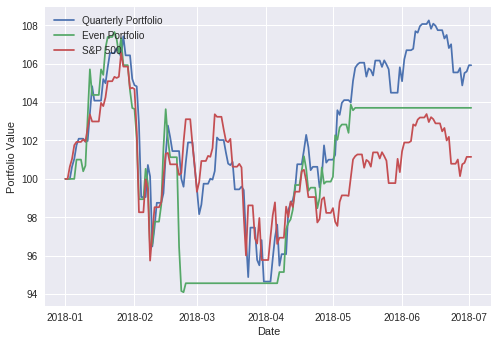

Quarterly Portfolio Return: 5.92%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 4.77%

Even Portfolio Return: 3.70%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 2.55%


In [34]:
print('JUST ALL_DATA')
test_graph_portfolios(all_data, "01/01/2018", "07/01/2018", ["01/01/18", "07/01/2018"])
print("HISTORICAL BEATS STRATEGY")
test_graph_portfolios(new_historical_beats_strategy(all_data), "01/01/2018", "07/01/2018", ["01/01/18", "07/01/2018"])
print("PCT CHANGE STRATEGY")
test_graph_portfolios(pct_change_strategy(all_data, 0.01528191923264529), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("DATE CHANGE STRATEGY 4,6")
test_graph_portfolios(date_change_strategy(all_data, 4, 6), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("SECTOR STRATEGY")
test_graph_portfolios(sector_strategy(all_data), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
# test_graph_portfolios(modified_historical_beats_strategy(all_data, 0.8), "1/1/2018", "7/01/2018")
print("LONG STRATEGY")
test_graph_portfolios(long_strategy(all_data), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("FACILITY STRATEGY")
test_graph_portfolios(facility_strategy(all_data, True), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("BETA STRATEGY 1.0")
test_graph_portfolios(beta_strategy(all_data, 1.0), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("BETA STRATEGY 1.5")
test_graph_portfolios(beta_strategy(all_data, 1.5), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("HISTORICAL BEATS & PCT CHANGE & DATE CHANGE")
test_graph_portfolios(new_historical_beats_strategy(pct_change_strategy(all_data, 0.01528191923264529)), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("HISTORICAL BEATS & DATE CHANGE & LONG & SECTOR & FACILITY")
test_graph_portfolios(new_historical_beats_strategy(date_change_strategy(long_strategy(sector_strategy(facility_strategy(all_data, False))), 6, 4)), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("PCT CHANGE & DATE CHANGE & LONG & SECTOR & FACILITY")
test_graph_portfolios(pct_change_strategy((date_change_strategy(long_strategy(sector_strategy(facility_strategy(all_data, False))), 6, 4)), 0.0025290852396864746), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])

JUST XMODE DATA
Total Number of Trades:  184


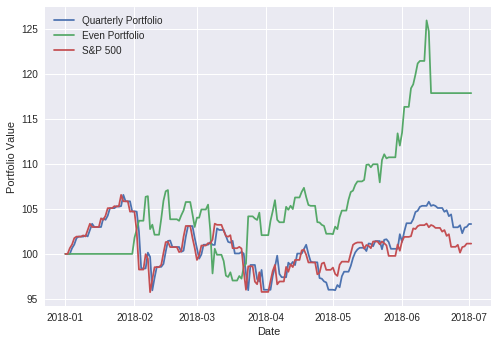

Quarterly Portfolio Return: 3.33%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 2.18%

Even Portfolio Return: 17.88%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 16.74%
HISTORICAL BEATS STRATEGY
Total Number of Trades:  49


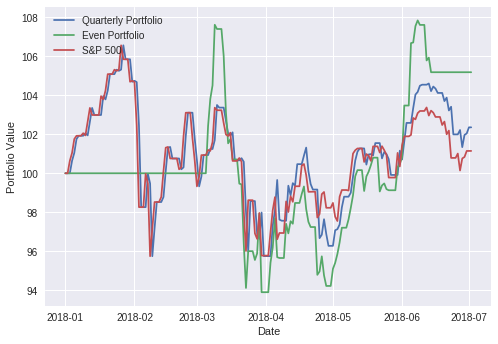

Quarterly Portfolio Return: 2.36%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 1.21%

Even Portfolio Return: 5.19%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 4.04%
PCT CHANGE STRATEGY
Total Number of Trades:  82


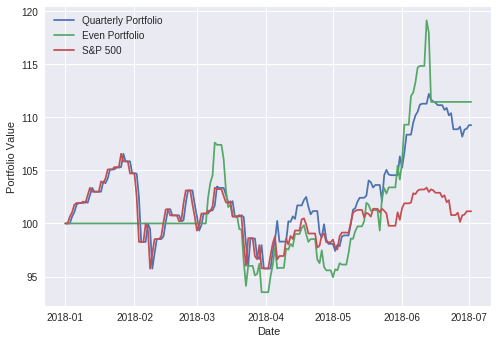

Quarterly Portfolio Return: 9.26%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 8.11%

Even Portfolio Return: 11.45%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 10.31%
DATE CHANGE STRATEGY 4,6
Total Number of Trades:  186


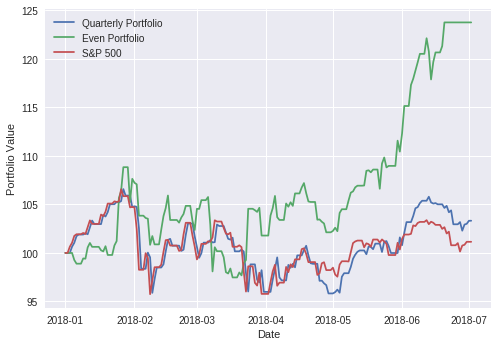

Quarterly Portfolio Return: 3.32%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 2.17%

Even Portfolio Return: 23.77%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 22.62%
SECTOR STRATEGY
Total Number of Trades:  97


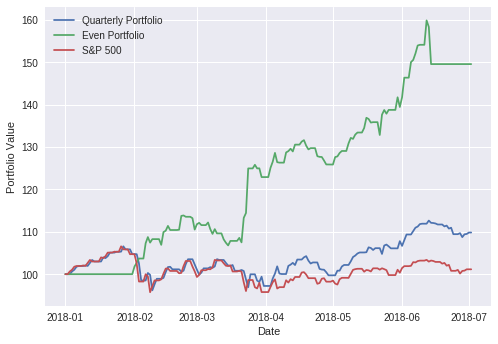

Quarterly Portfolio Return: 9.83%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 8.68%

Even Portfolio Return: 49.58%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 48.43%
LONG STRATEGY
Total Number of Trades:  183


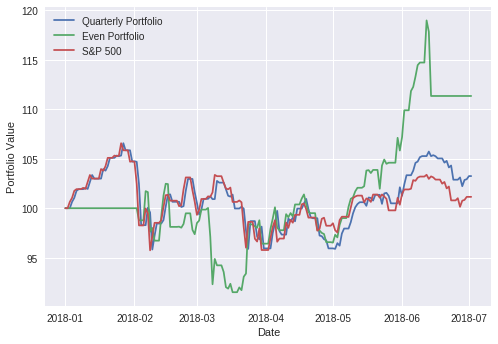

Quarterly Portfolio Return: 3.25%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 2.10%

Even Portfolio Return: 11.34%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 10.19%
FACILITY STRATEGY
Total Number of Trades:  79


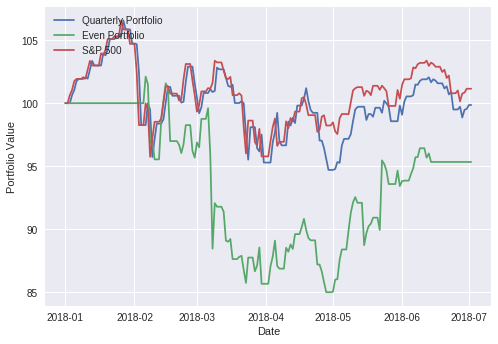

Quarterly Portfolio Return: -0.15%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: -1.29%

Even Portfolio Return: -4.67%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: -5.81%
BETA STRATEGY 1.0
Total Number of Trades:  84


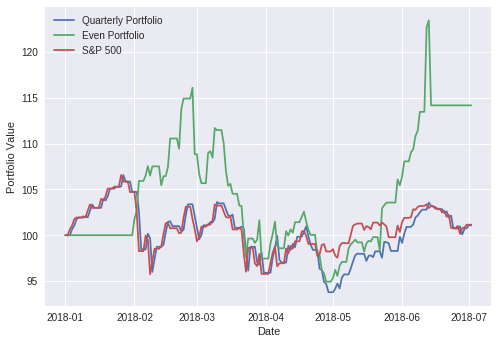

Quarterly Portfolio Return: 1.09%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: -0.06%

Even Portfolio Return: 14.17%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 13.02%
BETA STRATEGY 1.5
Total Number of Trades:  31


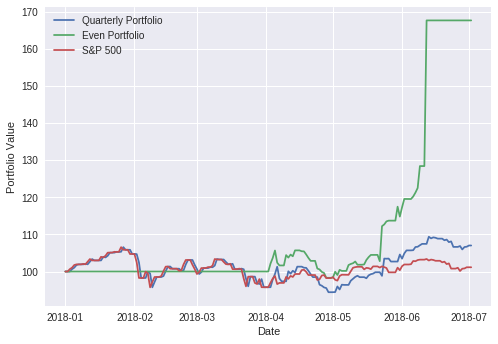

Quarterly Portfolio Return: 7.01%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 5.86%

Even Portfolio Return: 67.61%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 66.47%
HISTORICAL BEATS & PCT CHANGE
Total Number of Trades:  27


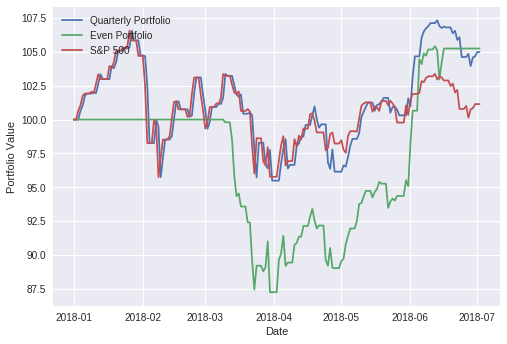

Quarterly Portfolio Return: 5.00%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 3.85%

Even Portfolio Return: 5.25%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 4.10%
HISTORICAL BEATS & DATE CHANGE & LONG & SECTOR & FACILITY
Total Number of Trades:  10


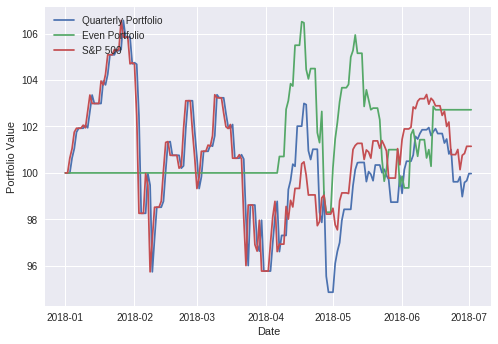

Quarterly Portfolio Return: -0.03%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: -1.17%

Even Portfolio Return: 2.72%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 1.57%
PCT CHANGE & DATE CHANGE & LONG & SECTOR & FACILITY
Total Number of Trades:  35


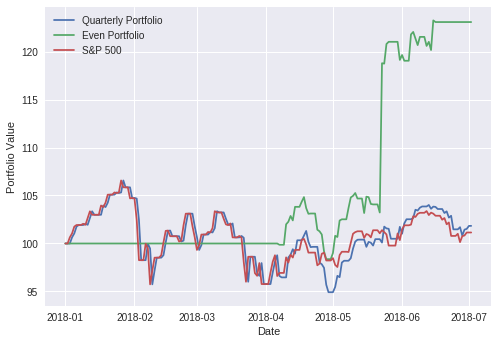

Quarterly Portfolio Return: 1.83%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 0.69%

Even Portfolio Return: 23.07%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 21.92%
HISTORICAL BEATS & PCT CHANGE & DATE CHANGE & LONG & NON-FACILITY
Total Number of Trades:  24


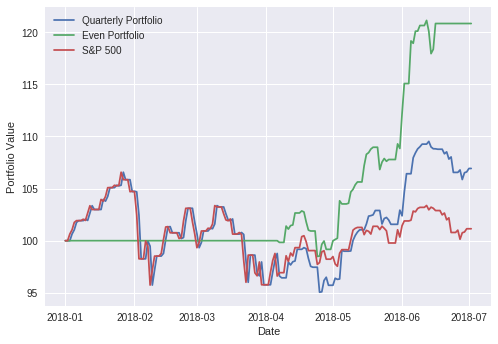

Quarterly Portfolio Return: 6.93%
S&P Return: 1.15%
Percent Points above S&P for Quarterly Portfolio: 5.78%

Even Portfolio Return: 20.83%
S&P Return: 1.15%
Percent Points above S&P for Even Portfolio: 19.68%


In [44]:
print('JUST XMODE DATA')
test_graph_portfolios(merged, "01/01/2018", "07/01/2018", ["01/01/18", "07/01/2018"])
print("HISTORICAL BEATS STRATEGY")
test_graph_portfolios(new_historical_beats_strategy(merged), "01/01/2018", "07/01/2018", ["01/01/18", "07/01/2018"])
print("PCT CHANGE STRATEGY")
test_graph_portfolios(pct_change_strategy(merged, 0.01528191923264529), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("DATE CHANGE STRATEGY 4,6")
test_graph_portfolios(date_change_strategy(merged, 4, 6), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("SECTOR STRATEGY")
test_graph_portfolios(sector_strategy(merged), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
# test_graph_portfolios(modified_historical_beats_strategy(merged, 0.8), "1/1/2018", "7/01/2018")
print("LONG STRATEGY")
test_graph_portfolios(long_strategy(merged), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("FACILITY STRATEGY")
test_graph_portfolios(facility_strategy(merged, True), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("BETA STRATEGY 1.0")
test_graph_portfolios(beta_strategy(merged, 1.0), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("BETA STRATEGY 1.5")
test_graph_portfolios(beta_strategy(merged, 1.5), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("HISTORICAL BEATS & PCT CHANGE")
test_graph_portfolios(new_historical_beats_strategy(date_change_strategy(pct_change_strategy(merged, 0.01528191923264529), 6, 4)), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("HISTORICAL BEATS & DATE CHANGE & LONG & SECTOR & FACILITY")
test_graph_portfolios(new_historical_beats_strategy(date_change_strategy(long_strategy(sector_strategy(facility_strategy(merged, True))), 6, 4)), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("PCT CHANGE & DATE CHANGE & LONG & SECTOR & FACILITY")
test_graph_portfolios(pct_change_strategy((date_change_strategy(long_strategy(sector_strategy(facility_strategy(merged, True))), 6, 4)), 0.0025290852396864746), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])
print("HISTORICAL BEATS & PCT CHANGE & DATE CHANGE & LONG & NON-FACILITY")
test_graph_portfolios(new_historical_beats_strategy(pct_change_strategy((date_change_strategy(long_strategy(facility_strategy(merged, False)), 6, 4)), 0.0025290852396864746)), "1/1/2018", "7/01/2018", ["01/01/18", "07/01/2018"])

"Private" Test Set

Total Number of Trades:  57


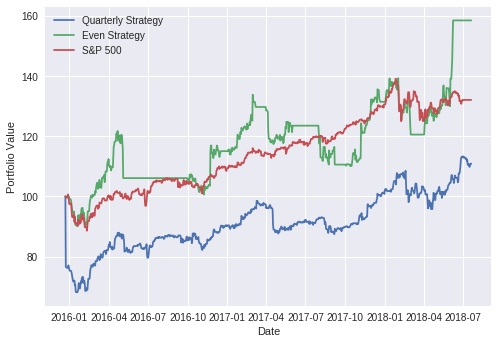

Quarterly Strategy Return:  0.10910599668193513 %
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Quarterly Strategy:  -21.18 %

Even Strategy Return:  0.5852503961530382
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Even Strategy:  26.44 %
Total Number of Trades:  332


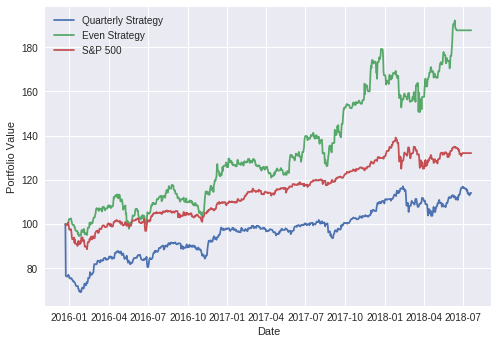

Quarterly Strategy Return:  0.14095976852482722 %
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Quarterly Strategy:  -17.99 %

Even Strategy Return:  0.876231734384098
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Even Strategy:  55.53 %
Total Number of Trades:  106


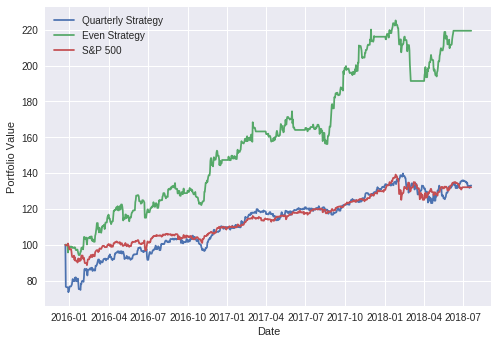

Quarterly Strategy Return:  0.33047665571262885 %
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Quarterly Strategy:  0.96 %

Even Strategy Return:  1.1940146556959985
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Even Strategy:  87.31 %
Total Number of Trades:  7


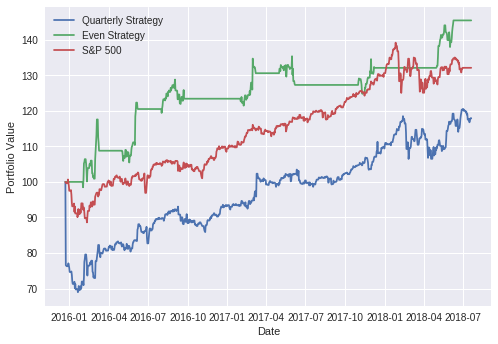

Quarterly Strategy Return:  0.17930308660097055 %
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Quarterly Strategy:  -14.16 %

Even Strategy Return:  0.4542127359163996
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Even Strategy:  13.33 %
Total Number of Trades:  301


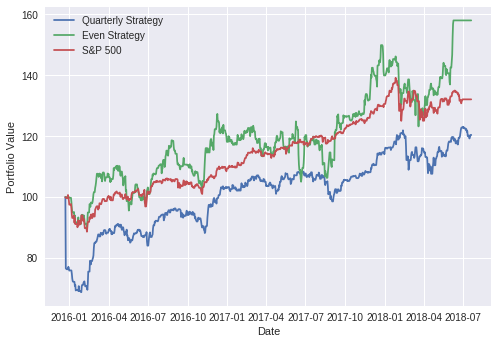

Quarterly Strategy Return:  0.20429845231773072 %
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Quarterly Strategy:  -11.66 %

Even Strategy Return:  0.580224817806045
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Even Strategy:  25.93 %
Total Number of Trades:  123


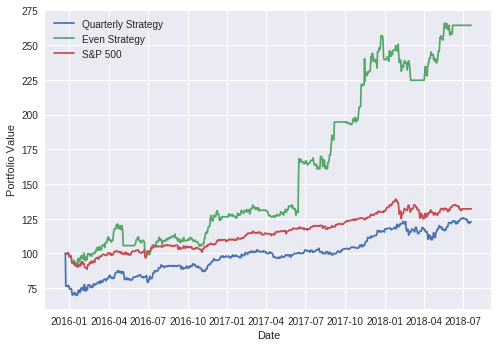

Quarterly Strategy Return:  0.2278861659511334 %
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Quarterly Strategy:  -9.3 %

Even Strategy Return:  1.6419713062969998
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Even Strategy:  132.11 %
Total Number of Trades:  143


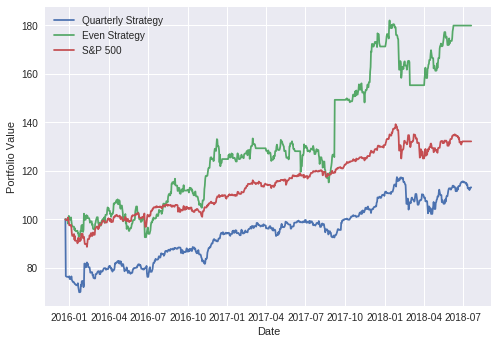

Quarterly Strategy Return:  0.13139930883706952 %
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Quarterly Strategy:  -18.95 %

Even Strategy Return:  0.7983050801872483
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Even Strategy:  47.74 %
Total Number of Trades:  51


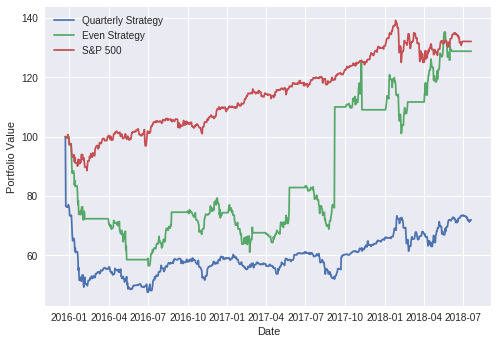

Quarterly Strategy Return:  -0.28018107180228197 %
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Quarterly Strategy:  -60.11 %

Even Strategy Return:  0.2878830384147659
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Even Strategy:  -3.3 %


In [73]:
trading_periods = ['12/23/2015', '03/01/2016', '06/01/2016', '09/01/2016', '12/01/2016', '03/01/2017', '06/01/2017', '09/01/2017', '12/01/2017', '03/01/2018', '07/01/2018']
test_graph_portfolios(pct_change_strategy(hidden_test, 0.01528191923264529), "12/23/2015", "7/01/2018", trading_periods)
test_graph_portfolios(date_change_strategy(hidden_test, 4, 6), "12/23/2015", "7/01/2018", trading_periods)
test_graph_portfolios(sector_strategy(hidden_test), "12/23/2015", "7/01/2018", trading_periods)
test_graph_portfolios(historical_beats_strategy(hidden_test, 0.8), "12/23/2015", "7/01/2018", trading_periods)
test_graph_portfolios(long_strategy(hidden_test), "12/23/2015", "7/01/2018", trading_periods)
test_graph_portfolios(facility_strategy(hidden_test, True), "12/23/2015", "7/01/2018", trading_periods)
test_graph_portfolios(beta_strategy(hidden_test, 1.0), "12/23/2015", "7/01/2018", trading_periods)
test_graph_portfolios(beta_strategy(hidden_test, 1.5), "12/23/2015", "7/01/2018", trading_periods)

Total Number of Trades:  105


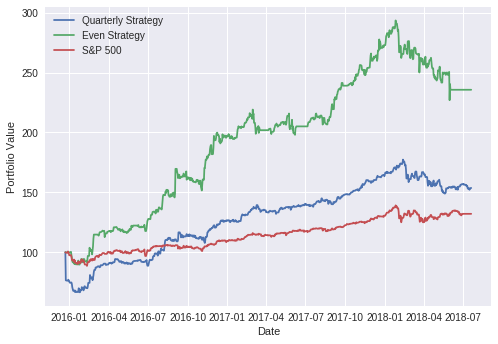

Quarterly Strategy Return:  0.537057487829728 %
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Quarterly Strategy:  21.62 %

Even Strategy Return:  1.3567144549301793
S&P Return:  0.3208947916645002 %
Percent Points above S&P for Even Strategy:  103.58 %


In [75]:
trading_periods = ['12/23/2015', '03/01/2016', '06/01/2016', '09/01/2016', '12/01/2016', '03/01/2017', '06/01/2017', '09/01/2017', '12/01/2017', '03/01/2018', '07/01/2018']
test_graph_portfolios(pct_change_strategy((date_change_strategy(long_strategy(sector_strategy(facility_strategy(advan, False))), 6, 4)), 0.0025290852396864746), '12/23/2015', '07/01/2018', trading_periods)

# MISC.

BEFORE DROP 1194
AFTER DROP 274
change in return with threshold of  0.0017060040359697798  is  0.014907022056447228
BEFORE DROP 270
AFTER DROP 270
change in return with threshold of  0.0028903362647409916  is  0.015172807271402418
BEFORE DROP 265
AFTER DROP 265
change in return with threshold of  0.003832744619727998  is  0.017225299172331548
BEFORE DROP 254
AFTER DROP 254
change in return with threshold of  0.004909931233246279  is  0.01696206702855174
BEFORE DROP 232
AFTER DROP 232
change in return with threshold of  0.007427757619454393  is  0.017451354198796527
BEFORE DROP 184
AFTER DROP 184
change in return with threshold of  0.009989994487225352  is  0.02057233360787833
BEFORE DROP 142
AFTER DROP 142
change in return with threshold of  0.012548275917091446  is  0.014823250535270883
BEFORE DROP 98
AFTER DROP 98
change in return with threshold of  0.01528191923264529  is  0.023265843932503798
BEFORE DROP 48
AFTER DROP 48
change in return with threshold of  0.02172794589314688  is  

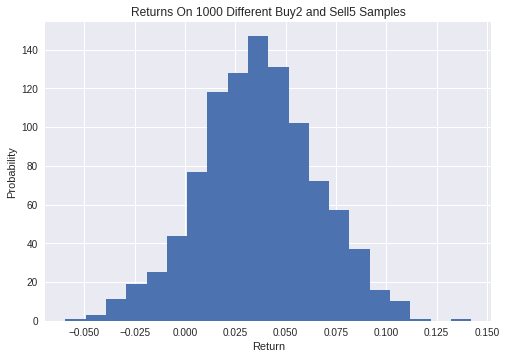

mean 0.03669649693421848
stddev 0.02904486219672726
0.014510614530728994
Difference between us and S&P with 1000 samples 0.02218588240348949


In [78]:
new_table = date_change_strategy(advan, -2, 4)
new_table = mult_pct_change(new_table, False)
new_table.reset_index(drop=True, inplace=True)
samp, stock_return, sp_return = test(new_table)
visualize(samp, 10)

In [0]:
new_table = advan.copy(deep=True)
best_return, sp_best, best_start, best_end, best_difference = test_date_change(new_table)
print(best_return, sp_best, best_start, best_end, best_difference)

In [0]:
from google.colab import files

final_table.to_csv('advan_returns.csv')
files.download('advan_returns.csv')

In [0]:
def dist_all(table):
  money_per_day = []
  money = 100.00
  stakes = []
  date_range = pd.date_range(pd.to_datetime('12/23/2015'), pd.to_datetime('8/31/2017'))
  for date in date_range:
    
    for stake in stakes:
      stake.update(date)
      
    to_sell = []
    todays_sells = table[table["sell_date"] == date]
    for row in range(len(todays_sells)):
      to_sell.append(todays_sells.iloc[row]["ticker"])

    new_stakes = []
    for stake in stakes:
      if stake.ticker not in to_sell:
        money += stake.money
        stake.money = 0
        new_stakes.append(stake) 
      else:
        money += stake.money
        
    money_per_day.append(money)
    stakes = new_stakes
    todays_buys = table[table["buy_date"] == date]
    num_stocks = len(todays_buys) + len(stakes)
    if num_stocks == 0:
      num_stocks = 1
    dollar_per_stock = money / float(num_stocks)
    
    
    for row in range(len(todays_buys)):
      new_stake = Stake(todays_buys.iloc[row]["ticker"], 0, date, todays_buys.iloc[row]["long_short"])
      stakes.append(new_stake)
    for stake in stakes:
      stake.money = dollar_per_stock
      money -= dollar_per_stock
      
  return money_per_day

In [0]:
def find_industry(ticker):
  '''
  Returns a tuple (Sector, Industry)
  '''
  url = "https://finance.yahoo.com/quote/{0}/profile?p={0}".format(ticker)
  page = urllib.request.urlopen(url)
  soup = BeautifulSoup(page, "html.parser")
  ps = soup.find_all("p", "D(ib) Va(t)")
  results = []
  counter = 0
  counter_thing = 0

  for p in ps:
    if "Industry" in p.text and "Sector" in p.text:
      for thing in p:
        if counter_thing == 4 or counter_thing == 10:
          results.append(thing.string)
        counter_thing += 1
  if len(results) == 0:
    return [None, None]
  return results[0], results[1]


In [112]:
sectors = []
industries = []
for row in range(len(hidden_test)):
  sector, industry = find_industry(hidden_test.iloc[row]["ticker"])
  sectors.append(sector)
  industries.append(industry)
hidden_test["sector"] = sectors
hidden_test["industry"] = industries
hidden_test.head()

HTTPError: ignored

In [0]:
from google.colab import files

hidden_test.to_csv('hidden_test.csv')
files.download('hidden_test.csv')

In [110]:
advan[(advan["sector"]==None) | (advan["industry"] == None)]

,ticker,type,start,buy_date,sales,estimate,est_low,est_high,advan_forecast,correct_beat_or_miss,sell_date,sector,industry,beta,long_short


In [0]:
def get_beta_values(table):
  beta_dict = {}
  betas = []
  beta_table = pd.read_csv("https://gist.githubusercontent.com/sethsaps123/172c48486019cca13ea014d073cd7ef3/raw/da76466eca99fd52a4b12f696212286a64acd707/beta_table")
  for row in range(len(beta_table)):
    ticker = beta_table.iloc[row]["ticker"]
    beta = beta_table.iloc[row]["BETA"]
    beta_dict[ticker] = beta
  for row in range(len(table)):
    ticker = table.iloc[row]["ticker"]
    beta = beta_dict[ticker]
    betas.append(beta)

  table["beta"] = betas
  return table
  